In [79]:
import numpy
import numpy as np
import pandas as pd
import os

FOLDER_NAME = "HnM"
FILE_NAME = "transactions_train.csv"
SAVE_FOLDER = 'Narrowed_HnM'
SAVE_LOCATION = f'{FOLDER_NAME}/{SAVE_FOLDER}/{FILE_NAME.split(".")[0]}'
if not os.path.isdir(f"{FOLDER_NAME}/{SAVE_FOLDER}"):
    os.mkdir(f'{FOLDER_NAME}/{SAVE_FOLDER}')
TOP_N = 0 # Positive Integer for top n items, 0 for hand-picked values
Y_VALUE_PERIOD_DAYS = 30

In [2]:
df = pd.read_csv(f"{FOLDER_NAME}/{FILE_NAME}", dtype={"article_id": "str"})

In [3]:
df.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,0.016932,2


In [64]:
import time
import datetime

def create_apk_evaluation_subset(transactions, days):
    transactions["timestamp"] = transactions["t_dat"].apply(lambda x: time.mktime(datetime.datetime.strptime(x, "%Y-%m-%d").timetuple()))
    now_timestamp = transactions["timestamp"].max()
    transactions["days_since_transaction"] = transactions["timestamp"].apply(lambda x: (now_timestamp - x) // (60*60*24))
    transactions_subset = transactions[transactions["timestamp"] > (transactions["timestamp"].max() - 60*60*24*days)]
    #transactions_y_values = transactions_subset.groupby("customer_id")["article_id"].aggregate(lambda x: " ".join(x)).reset_index()
    transactions_y_values = transactions_subset.groupby("customer_id")["article_id"].apply(list).aggregate(lambda x: x).reset_index()
    transactions_y_timestamp = transactions_subset.groupby("customer_id")["days_since_transaction"].apply(list).aggregate(lambda x: x).reset_index()
    transactions_y_values = pd.merge(transactions_y_values, transactions_y_timestamp, how="inner", on="customer_id")

    transactions_subset_train = transactions[transactions["timestamp"] < (transactions["timestamp"].max() - 60*60*24*days)]
    transactions_x_values = transactions_subset_train.groupby("customer_id")["article_id"].apply(list).aggregate(lambda x: x).reset_index()
    transactions_x_timestamps = transactions_subset_train.groupby("customer_id")["days_since_transaction"].apply(list).aggregate(lambda x: x).reset_index()
    transactions_x_values = pd.merge(transactions_x_values, transactions_x_timestamps, how="inner", on="customer_id")
    return transactions_y_values, transactions_x_values

y_vals, x_vals = create_apk_evaluation_subset(df.copy(), Y_VALUE_PERIOD_DAYS)
y_vals

,customer_id,article_id,days_since_transaction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,[0568601043],[17.0]
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,[0794321007],[7.0]
2,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,"[0719530003, 0448509014]","[8.0, 8.0]"
3,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,"[0562245099, 0516859008, 0921226007, 088965200...","[23.0, 23.0, 23.0, 23.0, 23.0, 23.0]"
4,0000b2f1829e23b24feec422ef13df3ccedaedc85368e6...,"[0706016038, 0914441005, 0706016015, 0778476005]","[24.0, 24.0, 24.0, 24.0]"
...,...,...,...
245940,fffd870c6324ad3bda24e4d6aeae221c199479086bfdfd...,"[0750423010, 0761269001]","[6.0, 6.0]"
245941,fffef3b6b73545df065b521e19f64bf6fe93bfd450ab20...,"[0934054002, 0834906012, 0786187002, 086507600...","[29.0, 24.0, 24.0, 24.0, 24.0, 13.0, 13.0, 13...."
245942,ffff12aa623c69eae8959d673f1f12ad0194ad760d77fd...,"[0871664001, 0869706005]","[29.0, 29.0]"
245943,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,"[0713997002, 0720125039, 0740922009, 079158700...","[16.0, 16.0, 16.0, 16.0, 16.0, 16.0]"


In [65]:
def detect_transaction_length_mismatch(input_df):
    df_copy = input_df.copy()
    df_copy["lens_article_id"] = df_copy["article_id"].apply(len)
    df_copy["lens_days_since_transaction"] = df_copy["days_since_transaction"].apply(len)
    df_copy["len_diff"] = df_copy["lens_article_id"] - df_copy["lens_days_since_transaction"]
    diff_array = df_copy["len_diff"].to_numpy().nonzero()
    return df_copy, diff_array

diff_df_y, diff_array_y = detect_transaction_length_mismatch(y_vals)
print("Y_vals: ", diff_array_y)
diff_df_x, diff_array_x = detect_transaction_length_mismatch(y_vals)
print("X_vals: ", diff_array_x)

Y_vals:  (array([], dtype=int64),)
X_vals:  (array([], dtype=int64),)


In [66]:
x_vals.head()

,customer_id,article_id,days_since_transaction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,"[0625548001, 0176209023, 0627759010, 069713800...","[634.0, 634.0, 634.0, 509.0, 486.0, 486.0, 425..."
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,"[0583558001, 0639677008, 0640244003, 052126900...","[732.0, 732.0, 732.0, 728.0, 728.0, 726.0, 726..."
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[0663713001, 0541518023, 0663713001, 057802000...","[733.0, 733.0, 729.0, 570.0, 231.0, 231.0, 231..."
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,"[0742079001, 0732413001]","[471.0, 471.0]"
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,"[0634249005, 0677049001, 0698286003, 070770400...","[711.0, 711.0, 564.0, 564.0, 357.0, 349.0, 111..."


In [67]:
x_vals.shape, y_vals.shape, df.shape

((1337403, 3), (245945, 3), (31788324, 5))

In [68]:
x_value_count_series = x_vals["article_id"].explode().value_counts()
print(x_value_count_series.shape)
x_value_count_series

(100651,)


0706016001    47792
0706016002    34044
0372860001    30572
0610776002    28977
0759871002    26130
              ...  
0896912001        1
0255396010        1
0522996003        1
0563737001        1
0568499001        1
Name: article_id, Length: 100651, dtype: int64

In [69]:
y_value_count_series = y_vals["article_id"].explode().value_counts()
print(y_value_count_series.shape)
y_value_count_series

(28889,)


0751471001    2936
0915526001    2478
0915529003    2468
0918292001    2418
0706016001    2413
              ... 
0902864001       1
0773278001       1
0526751002       1
0802821001       1
0896214001       1
Name: article_id, Length: 28889, dtype: int64

In [81]:
# 0685814001, menswear, Jersey, 998
# 0751471001, ladieswear, trousers, 2348
# 0915529003, ladieswear, sweater, 2200, knitwear
# 0896152002, ladierwear, t-shirt, 1427
# 0866731001, sports, leggins/tights, 1122

#test_y_vals = y_vals.copy()
# y_vals["article_id"] = y_vals["article_id"].apply(lambda x : x if type(x) == np.ndarray else np.array([x]))
# x_vals["article_id"] = x_vals["article_id"].apply(lambda x : x if type(x) == np.ndarray else np.array([x]))
y_vals["unique_article_id"] = y_vals["article_id"].apply(set)
hand_picked_ids = ["0685814001", "0751471001", "0915529003", "0896152002", "0866731001"]
#hand_picked_ids = ["0751471001", "0915529003"]
if TOP_N == 0:
    most_common_y_items = y_vals["unique_article_id"].explode().value_counts().loc[hand_picked_ids]
else:
    most_common_y_items = y_vals["unique_article_id"].explode().value_counts()[:TOP_N]

most_common_y_items

0685814001     998
0751471001    2348
0915529003    2200
0896152002    1427
0866731001    1122
Name: unique_article_id, dtype: int64

AttributeError: 'Rectangle' object has no property 'size'

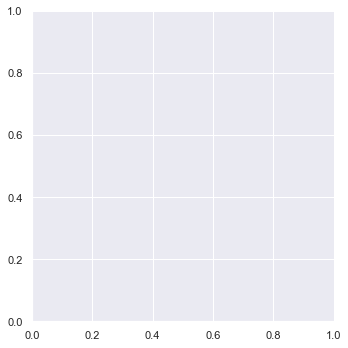

In [83]:
import seaborn as sns

inv_vals_y = y_vals.copy()
inv_vals_y["trans_len"] = inv_vals_y["article_id"].apply(lambda x: len(x))
sns.set_theme()
#sns.lineplot(data=inv_vals)
sns.displot(inv_vals_y["trans_len"], kde=True)

inv_vals_x = x_vals.copy()
inv_vals_x["trans_len"] = inv_vals_x["article_id"].apply(lambda x: len(x))
#sns.lineplot(data=inv_vals)
sns.displot(inv_vals_x["trans_len"], kde=True)
y_vals.size, x_vals.size

In [84]:
most_common_y_items.index

Index(['0685814001', '0751471001', '0915529003', '0896152002', '0866731001'], dtype='object')

In [86]:
#Filter lists columns based on whether in top_items. Ensures that the age index matches the filtered item index
y_vals["keep_indexes"] = y_vals["article_id"].apply(lambda x : [art_id in most_common_y_items for art_id in x])
y_vals["article_id"] = y_vals.apply(lambda x: np.array(x.article_id)[x.keep_indexes], axis=1)
y_vals["days_since_transaction"] = y_vals.apply(lambda x: np.array(x.days_since_transaction)[x.keep_indexes], axis=1)
y_vals = y_vals.drop(columns=["keep_indexes"], axis=0)
y_vals.head()

,customer_id,article_id,days_since_transaction,unique_article_id
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,[],[],{0568601043}
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,[],[],{0794321007}
2,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,[],[],"{0448509014, 0719530003}"
3,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,[],[],"{0889652001, 0921226007, 0797892001, 051685900..."
4,0000b2f1829e23b24feec422ef13df3ccedaedc85368e6...,[],[],"{0706016015, 0914441005, 0778476005, 0706016038}"


In [88]:
x_vals = x_vals[x_vals["article_id"].map(len) > 0]
x_vals["days_since_transaction"] = x_vals["days_since_transaction"].apply(np.asarray)
x_vals["article_id"] = x_vals["article_id"].apply(np.asarray)
print(detect_transaction_length_mismatch(x_vals)[1])
y_vals = y_vals[y_vals["article_id"].map(len) > 0]
print(detect_transaction_length_mismatch(y_vals)[1])

(array([], dtype=int64),)
(array([], dtype=int64),)


In [89]:
# y_vals["article_id"] = y_vals["article_id"].apply(lambda x : list(filter(lambda y: y in top_items, x)))
# #y_vals["article_len"] = y_vals["article_id"].apply(lambda x: len(x))
# y_vals = y_vals[y_vals["article_id"].map(len) > 0]

#x_vals["article_id"] = x_vals["article_id"].apply(lambda x : list(filter(lambda y: y in top_items, x)))
#test_x["article_len"] = test_x["article_id"].apply(lambda x: len(x))
#x_vals = x_vals[x_vals["article_id"].map(len) > 0]
#x_vals['article_id'].apply(lambda x: len(x)).value_counts()
y_vals['article_id'].apply(lambda x: len(x)).value_counts()

1     6710
2     1017
3      137
4       35
5        8
6        7
13       1
30       1
22       1
35       1
8        1
9        1
17       1
12       1
Name: article_id, dtype: int64

In [91]:
y_vals

,customer_id,article_id,days_since_transaction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,"[0625548001, 0176209023, 0627759010, 069713800...","[634.0, 634.0, 634.0, 509.0, 486.0, 486.0, 425..."
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,"[0583558001, 0639677008, 0640244003, 052126900...","[732.0, 732.0, 732.0, 728.0, 728.0, 726.0, 726..."
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[0663713001, 0541518023, 0663713001, 057802000...","[733.0, 733.0, 729.0, 570.0, 231.0, 231.0, 231..."
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,"[0742079001, 0732413001]","[471.0, 471.0]"
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,"[0634249005, 0677049001, 0698286003, 070770400...","[711.0, 711.0, 564.0, 564.0, 357.0, 349.0, 111..."
...,...,...,...
1337398,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,"[0698276003, 0699075005, 0694182002, 072243600...","[538.0, 538.0, 538.0, 538.0, 538.0, 538.0, 538..."
1337399,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,"[0671695001, 0562245015, 0562245018, 056224500...","[728.0, 671.0, 671.0, 671.0, 641.0, 558.0, 558..."
1337400,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,"[0568597019, 0484398001, 0484398001, 070108300...","[733.0, 705.0, 705.0, 657.0, 657.0, 657.0, 657..."
1337401,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,"[0821395003, 0806241002, 0714790020, 086675500...","[170.0, 170.0, 170.0, 166.0, 166.0, 150.0, 92.0]"


In [92]:
x_vals.shape, y_vals.shape, df.shape

((1337403, 3), (7922, 4), (31788324, 5))

In [93]:
all_y_values = y_vals["article_id"].explode()

In [94]:
y_count_sum = all_y_values.value_counts().sum()
y_value_counts = all_y_values.value_counts()
for article_id, art_count in zip(y_value_counts.index, y_value_counts.values):
    print(f"Article_id: {article_id}, total count: {art_count}, percent of total: {art_count/y_count_sum :.4}%")

Article_id: 0751471001, total count: 2936, percent of total: 0.3083%
Article_id: 0915529003, total count: 2468, percent of total: 0.2592%
Article_id: 0896152002, total count: 1602, percent of total: 0.1682%
Article_id: 0866731001, total count: 1272, percent of total: 0.1336%
Article_id: 0685814001, total count: 1245, percent of total: 0.1307%


In [95]:
x_vals['article_id'].apply(lambda x: len(x)).value_counts()

1      128651
2      124964
3       93982
4       80864
5       63774
        ...  
741         1
640         1
654         1
782         1
678         1
Name: article_id, Length: 728, dtype: int64

In [22]:
x_vals.shape, y_vals.shape

((1337403, 3), (10431, 4))

In [96]:
column_merge = pd.merge(x_vals, y_vals, on='customer_id', how='inner')
print(column_merge.shape)
column_merge.head(50)

(7362, 6)


,customer_id,article_id_x,days_since_transaction_x,article_id_y,days_since_transaction_y,unique_article_id
0,000172a9c322560c849754ffbdfdb2180d408aa7176b94...,"[0670942008, 0380609037, 0554811021, 070573200...","[458.0, 458.0, 458.0, 458.0, 458.0, 458.0, 458...","[0685814001, 0685814001, 0685814001]","[18.0, 18.0, 18.0]",{0685814001}
1,00077dbd5c4a4991e092e63893ccf29294a9d5c46e8501...,"[0676387001, 0685687003, 0662980003, 052995300...","[729.0, 729.0, 692.0, 692.0, 598.0, 598.0, 592...",[0915529003],[1.0],"{0915529003, 0929744001, 0486639003, 086579900..."
2,0016640d72ad1bcfe8dc30d8be1da4426d172fc2d88189...,"[0675657001, 0624632001, 0664338002, 056747500...","[729.0, 718.0, 705.0, 705.0, 705.0, 697.0, 697...",[0896152002],[21.0],"{0896152002, 0893059004}"
3,001c45896cbadc098dd6b526ec66c81b2b18bfed057ba0...,"[0678983002, 0228257001, 0436261001, 022825700...","[719.0, 719.0, 641.0, 641.0, 641.0, 418.0, 418...",[0915529003],[13.0],"{0915529003, 0923340002, 0915487001, 0904297001}"
4,00250644a9628fb8c4aebabf555d3caabe44c99c74fbcf...,"[0700329005, 0599502013, 0711193004, 070573400...","[542.0, 542.0, 542.0, 542.0, 542.0, 542.0, 516...",[0751471001],[27.0],"{0857163001, 0874754016, 0885951001, 089843900..."
5,003e53ba4aafc06bedafebcdf4f7356bbab4ea75025c30...,"[0744630001, 0629746002, 0629746002, 015834000...","[484.0, 484.0, 484.0, 349.0, 349.0, 349.0, 349...","[0751471001, 0751471001]","[28.0, 28.0]","{0640021024, 0868823008, 0887681001, 075147100..."
6,00415737ad0daa6c1e16bbbca3baa69dfeb257e8ceef5f...,"[0657155001, 0240561001, 0608769002, 066880600...","[671.0, 671.0, 671.0, 671.0, 671.0, 671.0, 671...",[0915529003],[27.0],"{0915529001, 0845790002, 0881751002, 076786200..."
7,00493ab28704e178f00b8c86e5fbec159f40ebd97d7360...,"[0594264010, 0830667001, 0801512004, 089205100...","[214.0, 214.0, 195.0, 111.0, 111.0, 97.0, 97.0...","[0896152002, 0896152002]","[17.0, 14.0]","{0896152002, 0849493006, 0772902010, 0772902001}"
8,004d932f7a27ac3167c77db81d9cfd89392729e7f7e0d4...,"[0673873001, 0673873001, 0446224014, 067985400...","[713.0, 713.0, 520.0, 520.0, 520.0, 520.0, 520...","[0751471001, 0751471001, 0751471001, 0751471001]","[7.0, 7.0, 0.0, 0.0]","{0783346023, 0678942001, 0783346028, 075147100..."
9,00590a9eaa2794a26e8403fdbe589afdc9c911532a993a...,"[0565379001, 0565379004, 0636455012, 066971300...","[728.0, 728.0, 728.0, 728.0, 728.0, 726.0, 726...","[0915529003, 0751471001]","[21.0, 21.0]","{0915529003, 0751471001, 0871517016, 093176900..."


In [97]:
column_merge.drop("unique_article_id", inplace=True, axis=1)

In [98]:
column_merge

,customer_id,article_id_x,days_since_transaction_x,article_id_y,days_since_transaction_y
0,000172a9c322560c849754ffbdfdb2180d408aa7176b94...,"[0670942008, 0380609037, 0554811021, 070573200...","[458.0, 458.0, 458.0, 458.0, 458.0, 458.0, 458...","[0685814001, 0685814001, 0685814001]","[18.0, 18.0, 18.0]"
1,00077dbd5c4a4991e092e63893ccf29294a9d5c46e8501...,"[0676387001, 0685687003, 0662980003, 052995300...","[729.0, 729.0, 692.0, 692.0, 598.0, 598.0, 592...",[0915529003],[1.0]
2,0016640d72ad1bcfe8dc30d8be1da4426d172fc2d88189...,"[0675657001, 0624632001, 0664338002, 056747500...","[729.0, 718.0, 705.0, 705.0, 705.0, 697.0, 697...",[0896152002],[21.0]
3,001c45896cbadc098dd6b526ec66c81b2b18bfed057ba0...,"[0678983002, 0228257001, 0436261001, 022825700...","[719.0, 719.0, 641.0, 641.0, 641.0, 418.0, 418...",[0915529003],[13.0]
4,00250644a9628fb8c4aebabf555d3caabe44c99c74fbcf...,"[0700329005, 0599502013, 0711193004, 070573400...","[542.0, 542.0, 542.0, 542.0, 542.0, 542.0, 516...",[0751471001],[27.0]
...,...,...,...,...,...
7357,ffbbfc905e3bdd3ea7e0a8a75ab7e3a4f46071452c5e21...,"[0677511001, 0639677001, 0677506003, 071261600...","[682.0, 682.0, 682.0, 638.0, 625.0, 625.0, 620...",[0915529003],[17.0]
7358,ffbe3e5c5e3ef4484c2f193ea279ee9b2c994644781fe8...,"[0626263006, 0578382003, 0624066007, 064527500...","[726.0, 726.0, 726.0, 726.0, 726.0, 726.0, 726...",[0751471001],[20.0]
7359,ffd06cb94f22fa87ee21e9ad894127af2e67884e5c5f2b...,"[0639576002, 0764618001, 0707488007, 079919000...","[633.0, 451.0, 451.0, 318.0, 315.0, 171.0, 171.0]",[0685814001],[11.0]
7360,ffd4ac08989849fbe3d2889a0b0ee5ed16b0db6aa9bad5...,"[0625311006, 0182909001, 0179208001, 073609000...","[632.0, 632.0, 632.0, 546.0, 546.0, 546.0, 546...",[0866731001],[24.0]


In [101]:
#y_vals.to_csv(SAVE_LOCATION + "_narrowed_Y.csv")
#x_vals.to_csv(SAVE_LOCATION + '_narrowed_X.csv')
column_merge.to_csv(SAVE_LOCATION + f'_narrowed_Xy_{Y_VALUE_PERIOD_DAYS}days_{TOP_N if TOP_N != 0 else f"{len(most_common_y_items)}(custom)"}items.csv')
most_common_y_items.to_csv(SAVE_LOCATION + f'_narrowed_topN_{Y_VALUE_PERIOD_DAYS}days_{TOP_N if TOP_N != 0 else f"{len(most_common_y_items)}(custom)"}items.csv')